Current Notebook:
1. Copy V4
2. No Scaling only X 
3. Removing Initial Zero Demand values per series
4. Lag, Rolling & Stat Features
5. Sample Weights Removed
6. Undersampling for zero demand in train only


Exactly similar to V06 with more epochs

More Ideas:
1. Outliers in Demand columns.. Remove those greater than some threshold

In [1]:
MODEL_VERSION = "10"
NUM_TIMESTEPS = 28
RUN_ON_SAMPLE = False
SAMPLE_SIZE = 500
SCALING = False

DROPOUT = 0.3
MIN_LR = 1e-5
MAX_LR = 1e-2
STEP_SIZE = 2
BATCH_SIZE = 5*1024
PREDICT_BATCH_SIZE = 10*1024
NUM_EPOCHS = [8, 48, 8]

MC_DROPOUT = False
MC_SAMPLES = 10 if MC_DROPOUT else 1

In [2]:
import os, sys, datetime, pickle, gc
from time import time, ctime
from pprint import pprint
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RepeatVector, Lambda
from tensorflow.keras.backend import repeat_elements
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate
from tensorflow_addons.losses import PinballLoss

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
seeded_value = 88888
pd.set_option('display.max_colwidth', 50)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
# suppress scientific notation
pd.options.display.precision = 2
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
print([
    tf.__version__
])

['2.2.0']


In [7]:
start_time = time()
start = datetime.now()
print(ctime(start_time))

Sun Jun 28 18:36:18 2020


### Files
1. calendar.csv - Contains information about the dates on which the products are sold.
2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
3. sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
4. sell_prices.csv - Contains information about the price of the products sold per store and date.
5. sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

In [8]:
DATA_DIR = "../data/"
RESULTS_DIR = "../results/"
PICKLE_DIR = "../data/preprocessed/"

In [9]:
CARDINAL_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id']

In [10]:
EXCLUDE_INDICES = np.arange(1, 730 + 1)
TRAIN_INDICES = np.arange(731, 1885 + 1) # Could use 1156 i.e. only 2 years of data
VALID_INDICES = np.arange(1886, 1913 + 1)
PUBLIC_INDICES = np.arange(1914, 1941 + 1)
PRIVATE_INDICES = np.arange(1942, 1969 + 1)

In [11]:
print(min(TRAIN_INDICES), max(TRAIN_INDICES), len(TRAIN_INDICES))
print(min(VALID_INDICES), max(VALID_INDICES), len(VALID_INDICES))
print(min(PUBLIC_INDICES), max(PUBLIC_INDICES), len(PUBLIC_INDICES))
print(min(PRIVATE_INDICES), max(PRIVATE_INDICES), len(PRIVATE_INDICES))

731 1885 1155
1886 1913 28
1914 1941 28
1942 1969 28


Read about memory management in pandas [here](https://pythonspeed.com/articles/pandas-load-less-data/)

In [12]:
def diff_w_first(x:pd.Series, lag:int):
    x1 = x[:lag]
    x2  = x.diff(lag)[lag:]
    return pd.concat([x1, x2])

In [13]:
def add_features(df, grouping_col, col, roll_sizes, lag_sizes):
    
    # per series
    df[col+"_mean_s"] = df.groupby(grouping_col)[col].transform("mean")
    df[col+"_std_s"] = df.groupby(grouping_col)[col].transform("std")
    df[col+"_min_s"] = df.groupby(grouping_col)[col].transform("min")
    df[col+"_max_s"] = df.groupby(grouping_col)[col].transform("max")
    df[col+"_scaled_s"] = (df[col] - df[col+"_mean_s"]) / df[col+"_std_s"]
    
    # rolling window per series
    for i in roll_sizes:
        j = str(i)
        df[col+"_mean_rs_"+j] = df.groupby(grouping_col)[col].rolling(window=i, min_periods=1).mean().reset_index(drop=True)
        df[col+"_min_rs_"+j] = df.groupby(grouping_col)[col].rolling(window=i, min_periods=1).min().reset_index(drop=True)
        df[col+"_max_rs_"+j] = df.groupby(grouping_col)[col].rolling(window=i, min_periods=1).max().reset_index(drop=True)
        df[col+"_std_rs_"+j] = df.groupby(grouping_col)[col].rolling(window=i, min_periods=1).std().reset_index(drop=True)
        df[col+"_std_rs_"+j] = df[col+"_std_rs_"+j].fillna(1e-3)
    
    # various lags
    for i in lag_sizes:
        j = str(i)
        df[col+"_lag_"+j] = df.groupby(grouping_col)[col].apply(lambda x: diff_w_first(x,i)).reset_index(drop=False)[col]
    
    return df

In [14]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [15]:
def read_data(infer_mode:bool=False):
    print('Reading files...')
    
    calendar = pd.read_csv('../data/calendar.csv').fillna("None")
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    
    sell_prices = pd.read_csv('../data/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    
    sales = pd.read_csv('../data/sales_train_evaluation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    sales[['d_'+str(i) for i in PRIVATE_INDICES]] = pd.DataFrame(np.zeros(shape=(sales.shape[0], len(PRIVATE_INDICES))))
    print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    
    submission = pd.read_csv('../data/sample_submission.csv')
    
    pprint({
        "calendar.shape" : calendar.shape,
        "sell_prices.shape" : sell_prices.shape,
        "sales.shape" : sales.shape,
        "submission.shape" : submission.shape
    })
    
    return calendar, sell_prices, sales, submission

In [16]:
def add_dateparts(calendar, datecolname):
    calendar["Date"] = pd.to_datetime(calendar[datecolname], format = ("%Y-%m-%d"))
    calendar["Year"] = calendar["Date"].dt.year.astype('int16')
    calendar["Quarter"] = calendar["Date"].dt.quarter
    calendar["Month"] = calendar["Date"].dt.month
    calendar["Week"] = calendar["Date"].dt.week
    calendar["Day"] = calendar["Date"].dt.day
    calendar["DOW"] = calendar["Date"].dt.dayofweek
    calendar = reduce_mem_usage(calendar)
    return calendar

In [17]:
def melt_join_fill(sales, calendar, sell_prices):
    print("[INFO] ", "Starting  -- COMPLETE", ctime(time()))
    if RUN_ON_SAMPLE:
        sales = pd.melt(sales.sample(SAMPLE_SIZE),
                        id_vars=CARDINAL_VARS,
                        value_vars=Y_VARS,
                        var_name="day_id",
                        value_name='demand')
    else:
        sales = pd.melt(sales,
                        id_vars=CARDINAL_VARS,
                        value_vars=Y_VARS,
                        var_name="day_id",
                        value_name='demand')
    print("[INFO] ", "Melting  -- COMPLETE", ctime(time()))

    gc.collect()
    
    sales = pd.merge(sales, calendar, how="left", left_on="day_id", right_on="d")
    print("[INFO] ", "Merging1 -- COMPLETE", ctime(time()))
    
    gc.collect()
    
    sales = pd.merge(sales, sell_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
    print("[INFO] ", "Merging2 -- COMPLETE", ctime(time()))
    
    gc.collect()
    
    # if sell_price is NA
    sales = sales.sort_values(by=CARDINAL_VARS+["date"])
    print("[INFO] ", "Sorting -- COMPLETE", ctime(time()))
    
    # remove till first non-zero demand per series
    before = sales.shape
    sales['cumul_demand'] = sales.groupby(['id'])['demand'].cumsum()
    sales = sales.loc[sales['cumul_demand']>0].copy().reset_index(drop=True)
    after = sales.shape
    print("[INFO] ", "Removal -- COMPLETE", ctime(time()))
    print("[INFO] ", "Removal", before, "--->", after)
    
    gc.collect()    
    
    sales["sell_price_available"] = np.where(sales.sell_price.isna(), "N", "Y")
    sales[["sell_price"]] = sales.groupby(["item_id"])[["sell_price"]].ffill()
    sales[["sell_price"]] = sales.groupby(["item_id"])[["sell_price"]].bfill()
    sales = sales.drop(["d", "wday", 'date', 'wm_yr_wk', 'weekday', 'month', 'year'], axis=1)
    
    sales['day_id'] = sales['day_id'].astype(str).apply(lambda x: x[2:]).astype(np.int16)
    
    print("[INFO] ", "Imputing -- COMPLETE", ctime(time()))    
    
    gc.collect()
    
    sales['weights'] = sales["sell_price"] * sales["demand"]
    sales['rolling_weights'] = sales.groupby(CARDINAL_VARS)['weights'].rolling(window=NUM_TIMESTEPS, min_periods=1).sum().reset_index(drop=True)
    
    sales['weights'] = sales['weights'].apply(lambda x: np.max((1.0, x)))
    sales['rolling_weights'] = sales['rolling_weights'].apply(lambda x: np.max((1.0, x)))
    
    print("[INFO] ", "Weighting -- COMPLETE", ctime(time()))    
    
    gc.collect()
    
    print("[INFO] ", "Final dataset contains", sales.shape)
    
    return sales.reset_index(drop=True)

In [18]:
MODEL_VERSION = "06"
if not os.path.exists(PICKLE_DIR+"merged_df_"+MODEL_VERSION+".pickle"):
    
    calendar, sell_prices, sales, submission = read_data()
    
    calendar = add_dateparts(calendar, "date")
    
    Y_VARS = sales.columns[sales.columns.str.startswith("d_")]

    data = melt_join_fill(sales, calendar, sell_prices)
    
    del sales, calendar, sell_prices
    gc.collect()

    data["demand_lag"] = data.groupby('id')['demand'].apply(lambda x: diff_w_first(x,60)).reset_index(drop=False)['demand']
    data = add_features(df=data, grouping_col="id", col="demand_lag", roll_sizes=[7, 30, 90, 365], lag_sizes=[7, 30, 90, 365])

    print("Saving all data to ---> ", PICKLE_DIR, "merged_df_"+MODEL_VERSION+".pickle")
    with open(os.path.join(PICKLE_DIR, "merged_df_"+MODEL_VERSION+".pickle"),"wb") as f:
        pickle.dump((data), f, protocol=4)
else:
    print("Pickle exists hence loading from pickle file ---> ", PICKLE_DIR, "merged_df_"+MODEL_VERSION+".pickle")
    with open(os.path.join(PICKLE_DIR+"merged_df_"+MODEL_VERSION+".pickle"), "rb") as f:
        data = pickle.load(f)

MODEL_VERSION = "10"

Pickle exists hence loading from pickle file --->  ../data/preprocessed/ merged_df_06.pickle


In [19]:
print(data.columns)

Index(['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id', 'day_id',
       'demand', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'Date', 'Year',
       'Quarter', 'Month', 'Week', 'Day', 'DOW', 'sell_price', 'cumul_demand',
       'sell_price_available', 'weights', 'rolling_weights', 'demand_lag',
       'demand_lag_mean_s', 'demand_lag_std_s', 'demand_lag_min_s',
       'demand_lag_max_s', 'demand_lag_scaled_s', 'demand_lag_mean_rs_7',
       'demand_lag_min_rs_7', 'demand_lag_max_rs_7', 'demand_lag_std_rs_7',
       'demand_lag_mean_rs_30', 'demand_lag_min_rs_30', 'demand_lag_max_rs_30',
       'demand_lag_std_rs_30', 'demand_lag_mean_rs_90', 'demand_lag_min_rs_90',
       'demand_lag_max_rs_90', 'demand_lag_std_rs_90',
       'demand_lag_mean_rs_365', 'demand_lag_min_rs_365',
       'demand_lag_max_rs_365', 'demand_lag_std_rs_365', 'demand_lag_lag_7',
       'demand_lag_lag_30', 'demand_lag_lag_90', 'demand_lag_l

In [20]:
1913-28, 1913, 1913 + 28, 1913 + 28 + 28

(1885, 1913, 1941, 1969)

In [21]:
data.Date.min(), data.Date.max()#, data.Date.max() + 28, data.Date.max() + 28 + 28

(Timestamp('2011-01-29 00:00:00'), Timestamp('2016-06-19 00:00:00'))

In [22]:
print(data.shape); data.head()

(47649940, 53)


,state_id,store_id,cat_id,dept_id,item_id,id,day_id,demand,event_name_1,event_type_1,...,demand_lag_max_rs_90,demand_lag_std_rs_90,demand_lag_mean_rs_365,demand_lag_min_rs_365,demand_lag_max_rs_365,demand_lag_std_rs_365,demand_lag_lag_7,demand_lag_lag_30,demand_lag_lag_90,demand_lag_lag_365
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,1,3.00,None,None,...,3.00,0.00,3.00,3.00,3.00,0.00,3.00,3.00,3.00,3.00
1,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,2,0.00,None,None,...,3.00,2.12,1.50,0.00,3.00,2.12,0.00,0.00,0.00,0.00
2,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,3,0.00,None,None,...,3.00,1.73,1.00,0.00,3.00,1.73,0.00,0.00,0.00,0.00
3,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,4,1.00,None,None,...,3.00,1.41,1.00,0.00,3.00,1.41,1.00,1.00,1.00,1.00
4,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,5,4.00,None,None,...,4.00,1.82,1.60,0.00,4.00,1.82,4.00,4.00,4.00,4.00


# Preprocessing

In [23]:
CONT_VARS = ['snap_CA', 'snap_TX', 'snap_WI', 'sell_price',
             'demand_lag', 'demand_lag_mean_s', 'demand_lag_std_s', 'demand_lag_min_s',
             'demand_lag_max_s', 'demand_lag_scaled_s', 'demand_lag_mean_rs_7',
             'demand_lag_min_rs_7', 'demand_lag_max_rs_7', 'demand_lag_std_rs_7',
             'demand_lag_mean_rs_30', 'demand_lag_min_rs_30', 'demand_lag_max_rs_30',
             'demand_lag_std_rs_30', 'demand_lag_mean_rs_90', 'demand_lag_min_rs_90',
             'demand_lag_max_rs_90', 'demand_lag_std_rs_90', 'demand_lag_mean_rs_365',
             'demand_lag_min_rs_365', 'demand_lag_max_rs_365', 'demand_lag_std_rs_365',
             'demand_lag_lag_7', 'demand_lag_lag_30', 'demand_lag_lag_90', 'demand_lag_lag_365']
CAT_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'event_name_1',
            'event_type_1', 'event_name_2', 'event_type_2', 'Year', 'Quarter',
            'Month', 'Week', 'Day', 'DOW', 'sell_price_available']
DEP_VAR = ['demand']
WEIGHT_VAR = ['weights', 'rolling_weights']

## Sampling

In [24]:
data['set'] = np.where(data.day_id.isin(TRAIN_INDICES), "Train",
                       np.where(data.day_id.isin(VALID_INDICES), "Valid",
                                np.where(data.day_id.isin(PUBLIC_INDICES), "Public", "Private")))

In [25]:
data.groupby('set').agg({
    'id':'count',
    'day_id':[np.min, np.max]
})

id day_id      
            count   amin  amax
set                           
Private  13733172      1  1969
Public     853720   1914  1941
Train    32209328    731  1885
Valid      853720   1886  1913

In [26]:
data = data.drop(data[(data['set'] == "Train") & (data['demand'] == 0)].sample(frac=0.7).index).copy().reset_index()
gc.collect()

print("[INFO] ", "Sampling -- COMPLETE", ctime(time()))
print("[INFO] ", "Sampling --  ", data.shape)

[INFO]  Sampling -- COMPLETE Sun Jun 28 18:38:50 2020
[INFO]  Sampling --   (33934762, 55)


In [27]:
data[data['set'] == "Train"].groupby(['demand'])[['id']].count()

,id
demand,
0.00,5877933
1.00,5404135
2.00,2668177
3.00,1417576
4.00,853982
...,...
613.00,1
620.00,1
626.00,1


### Categorical Data

In [28]:
Category_Mapping = {}
for c in CAT_VARS:
    # convert columns to categories
    data[c+"_cat"] = data[c].astype("category")
    
    # save the mapping for later use
    Category_Mapping.update({c+"_cat" : dict(enumerate(data[c+"_cat"].cat.categories))})
    
    # Copy categories as integer codes
    data[c+"_cat"] = data[c+"_cat"].cat.codes

In [29]:
Unique_Dict ={}
for c in CAT_VARS:
    col = c+"_cat"
    Unique_Dict.update({col:{'min':data[col].min(), 
                             'max':data[col].max(), 
                             'nuniq':data[col].nunique(), 
                             'emb_sz':max(min(int(data[col].nunique() / 2), 10), 2)}})
pprint(Unique_Dict)

{'DOW_cat': {'emb_sz': 3, 'max': 6, 'min': 0, 'nuniq': 7},
 'Day_cat': {'emb_sz': 10, 'max': 30, 'min': 0, 'nuniq': 31},
 'Month_cat': {'emb_sz': 6, 'max': 11, 'min': 0, 'nuniq': 12},
 'Quarter_cat': {'emb_sz': 2, 'max': 3, 'min': 0, 'nuniq': 4},
 'Week_cat': {'emb_sz': 10, 'max': 52, 'min': 0, 'nuniq': 53},
 'Year_cat': {'emb_sz': 3, 'max': 5, 'min': 0, 'nuniq': 6},
 'cat_id_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'dept_id_cat': {'emb_sz': 3, 'max': 6, 'min': 0, 'nuniq': 7},
 'event_name_1_cat': {'emb_sz': 10, 'max': 30, 'min': 0, 'nuniq': 31},
 'event_name_2_cat': {'emb_sz': 2, 'max': 4, 'min': 0, 'nuniq': 5},
 'event_type_1_cat': {'emb_sz': 2, 'max': 4, 'min': 0, 'nuniq': 5},
 'event_type_2_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'item_id_cat': {'emb_sz': 10, 'max': 3048, 'min': 0, 'nuniq': 3049},
 'sell_price_available_cat': {'emb_sz': 2, 'max': 0, 'min': 0, 'nuniq': 1},
 'state_id_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'store_id_cat': {'e

In [30]:
NEW_CAT_VARS = [col+"_cat" for col in CAT_VARS]

### Numerical Data

In [31]:
if SCALING:
    MMS = MinMaxScaler()
    data[CONT_VARS] = MMS.fit_transform(data[CONT_VARS])
    
    MMS_Y = MinMaxScaler(feature_range=(0, 0.8))
    data[DEP_VAR] = MMS_Y.fit_transform(data[DEP_VAR])

# Cross Validation

In [32]:
train_data = data.loc[data.day_id.isin(TRAIN_INDICES)]
valid_data = data.loc[data.day_id.isin(VALID_INDICES)]
public_data = data.loc[data.day_id.isin(PUBLIC_INDICES)]
private_data = data.loc[data.day_id.isin(PRIVATE_INDICES)]
train_data.shape, valid_data.shape, public_data.shape, private_data.shape

((18494150, 71), (853720, 71), (853720, 71), (853720, 71))

In [33]:
data.shape[0] == train_data.shape[0] + valid_data.shape[0] + private_data.shape[0] + private_data.shape[0]

False

In [34]:
model_time = time()
model_t = datetime.now()
print(ctime(model_time))

Sun Jun 28 18:39:39 2020


# Model Specification

In [35]:
def build_model():
    layers = []
    inputs = []
    for i,col in enumerate(CAT_VARS):
        input_ = Input(shape=1, name=col+"_cat")
        embedding =  Embedding(Unique_Dict[col+"_cat"]['nuniq'],
                               Unique_Dict[col+"_cat"]['emb_sz'],
                               name='emb_'+col)(input_)
        vec = Flatten()(embedding)
        layers.append(vec)
        inputs.append(input_)
    
    for i, col in enumerate(CONT_VARS):
        input_ = Input(shape=1, name=col)
        layers.append(input_)
        inputs.append(input_)
    
    concat_layer = concatenate(layers)
    x = Dense(2048)(concat_layer)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)

    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(32)(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    if SCALING:
        demand = Dense(1, activation='sigmoid', name='demand')(x)
    else:
        demand = Dense(1, activation='relu', name='demand')(x)
    
    model = Model(inputs, demand)
    
    return model

In [36]:
model = build_model()

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_id_cat (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_id_cat (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_id_cat (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
dept_id_cat (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

In [38]:
gc.collect()

20

In [39]:
if os.path.exists(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5"):
    model.load_weights(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5")

In [40]:
tclr = TriangularCyclicalLearningRate(
    initial_learning_rate=MIN_LR,
    maximal_learning_rate=MAX_LR,
    step_size=STEP_SIZE * len(train_data)
)

In [41]:
mcp = ModelCheckpoint(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", monitor='val_loss',
                      verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')
csvl = CSVLogger(filename=RESULTS_DIR+"LossLogs_"+MODEL_VERSION+".csv",
                 separator=",", append=True)

In [42]:
PBL = PinballLoss(tau=[0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995])

In [43]:
adam = Adam(learning_rate=MAX_LR)
model.compile(loss= PBL if MC_DROPOUT else 'mse', optimizer=adam)

In [44]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
#                                      valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[0],
                    shuffle=True,
                    verbose=1,
#                     sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/8
3613/3613 [==============================] - 295s 82ms/step - loss: 4.1473 - val_loss: 2.6163
Epoch 2/8
3613/3613 [==============================] - 297s 82ms/step - loss: 3.3663 - val_loss: 2.1181
Epoch 3/8
3613/3613 [==============================] - 295s 82ms/step - loss: 3.0953 - val_loss: 2.1488
Epoch 4/8
3613/3613 [==============================] - 292s 81ms/step - loss: 2.8546 - val_loss: 2.1590
Epoch 5/8
3613/3613 [==============================] - 291s 81ms/step - loss: 2.6917 - val_loss: 1.9462
Epoch 6/8
3613/3613 [==============================] - 290s 80ms/step - loss: 2.5780 - val_loss: 4.6662
Epoch 7/8
3613/3613 [==============================] - 289s 80ms/step - loss: 2.4668 - val_loss: 1.9448
Epoch 8/8
3613/3613 [==============================] - 288s 80ms/step - loss: 2.3981 - val_loss: 2.1069


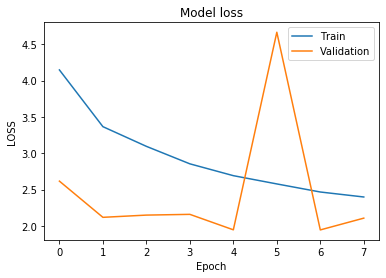

In [45]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [46]:
gc.collect()

10723

In [47]:
model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", compile=False)

In [48]:
adam = Adam(learning_rate=tclr)
model.compile(loss=PBL if MC_DROPOUT else 'mse', optimizer=adam)

In [49]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
#                                      valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[1],
                    shuffle=True,
                    verbose=1, 
#                     sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/48
3613/3613 [==============================] - 291s 81ms/step - loss: 2.3343 - val_loss: 1.7776
Epoch 2/48
3613/3613 [==============================] - 289s 80ms/step - loss: 2.2981 - val_loss: 1.7809
Epoch 3/48
3613/3613 [==============================] - 289s 80ms/step - loss: 2.2781 - val_loss: 1.7825
Epoch 4/48
3613/3613 [==============================] - 289s 80ms/step - loss: 2.2620 - val_loss: 1.7846
Epoch 5/48
3613/3613 [==============================] - 289s 80ms/step - loss: 2.2476 - val_loss: 1.7895
Epoch 6/48
3613/3613 [==============================] - 289s 80ms/step - loss: 2.2392 - val_loss: 1.7929
Epoch 7/48
3613/3613 [==============================] - 289s 80ms/step - loss: 2.2307 - val_loss: 1.7927
Epoch 8/48
3613/3613 [==============================] - 289s 80ms/step - loss: 2.2274 - val_loss: 1.7965
Epoch 9/48
3613/3613 [==============================] - 289s 80ms/step - loss: 2.2213 - val_loss: 1.7967
Epoch 10/48
3613/3613 [==============================] 

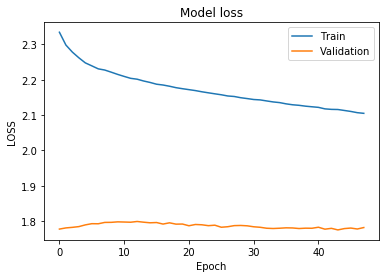

In [50]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model ' + i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [51]:
gc.collect()

54005

In [52]:
model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", compile=False)

In [53]:
adam = Adam(learning_rate=MIN_LR*0.1)
model.compile(loss=PBL if MC_DROPOUT else 'mse', optimizer=adam)

In [54]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
#                                      valid_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[2],
                    shuffle=True,
                    verbose=1, 
#                     sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['rolling_weights'],
                    callbacks=[mcp, csvl])

Epoch 1/8
3613/3613 [==============================] - 289s 80ms/step - loss: 2.1122 - val_loss: 1.7759
Epoch 2/8
3613/3613 [==============================] - 288s 80ms/step - loss: 2.1114 - val_loss: 1.7774
Epoch 3/8
3613/3613 [==============================] - 288s 80ms/step - loss: 2.1113 - val_loss: 1.7766
Epoch 4/8
3613/3613 [==============================] - 288s 80ms/step - loss: 2.1100 - val_loss: 1.7768
Epoch 5/8
3613/3613 [==============================] - 288s 80ms/step - loss: 2.1078 - val_loss: 1.7794
Epoch 6/8
3613/3613 [==============================] - 288s 80ms/step - loss: 2.1082 - val_loss: 1.7799
Epoch 7/8
3613/3613 [==============================] - 288s 80ms/step - loss: 2.1068 - val_loss: 1.7760
Epoch 8/8
3613/3613 [==============================] - 288s 80ms/step - loss: 2.1113 - val_loss: 1.7771


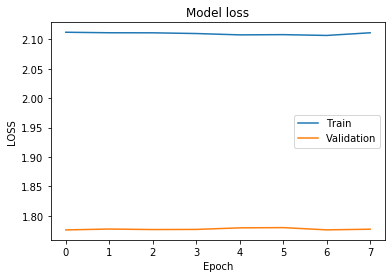

In [55]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [56]:
gc.collect()

18573

In [57]:
model.save(filepath=RESULTS_DIR+"FinalCheckpoint_"+MODEL_VERSION+".h5", overwrite=True)

# Validation

In [58]:
if os.path.exists(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5"):
    model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", compile=False)

In [59]:
gc.collect()

20

In [60]:
for i in range(MC_SAMPLES):
    if i == 0:
        train_preds = model.predict(train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)
        
        gc.collect()

        valid_preds = model.predict(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)

        gc.collect()
        
        public_preds = model.predict(public_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     batch_size=PREDICT_BATCH_SIZE, verbose=0)

        gc.collect()
        
        private_preds = model.predict(private_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                      batch_size=PREDICT_BATCH_SIZE, verbose=0)
        
        gc.collect()
    else:
        train_preds = np.concatenate((train_preds, 
                                      model.predict(train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

        gc.collect()
        
        valid_preds = np.concatenate((valid_preds, 
                                      model.predict(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

        gc.collect()
        
        public_preds = np.concatenate((public_preds, 
                                       model.predict(public_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                     batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

        gc.collect()
        
        private_preds = np.concatenate((private_preds, 
                                        model.predict(private_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                      batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)
        
        gc.collect()

print(train_preds.shape, valid_preds.shape, public_preds.shape, private_preds.shape)

(18494150, 1) (853720, 1) (853720, 1) (853720, 1)


In [61]:
if SCALING:
    train_demand = MMS_Y.inverse_transform(train_preds)
    valid_demand = MMS_Y.inverse_transform(valid_preds)
    public_demand = MMS_Y.inverse_transform(public_preds)
    private_demand = MMS_Y.inverse_transform(private_preds)
    
    data['prediction'] = 0
    data[['prediction']].loc[data.day_id.isin(TRAIN_INDICES)] = train_preds
    data[['prediction']].loc[data.day_id.isin(VALID_INDICES)] = valid_preds
    data[['prediction']].loc[data.day_id.isin(PUBLIC_INDICES)] = public_preds
    data[['prediction']].loc[data.day_id.isin(PRIVATE_INDICES)] = private_preds

    data['demand_Unscaled'] = MMS_Y.inverse_transform(data[['demand']])
    data[[col+'_Unscaled' for col in CONT_VARS]] = pd.DataFrame(MMS.inverse_transform(data[CONT_VARS]))

In [62]:
data['pred_demand'] = 0

if SCALING:
    data['pred_demand'].loc[data.day_id.isin(TRAIN_INDICES)] = train_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(VALID_INDICES)] = valid_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(PUBLIC_INDICES)] = public_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(PRIVATE_INDICES)] = private_demand.flatten()
else:
    data['pred_demand'].loc[data.day_id.isin(TRAIN_INDICES)] = train_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(VALID_INDICES)] = valid_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(PUBLIC_INDICES)] = public_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(PRIVATE_INDICES)] = private_preds.flatten()

/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [63]:
gc.collect()

20

In [64]:
for i in ['Train', 'Valid', 'Public', 'Private']:
    print(i)
    print('\t',{
        i+'_RMSE' : np.round(mean_squared_error(y_true = data['demand'].loc[data.set == i],
                                                y_pred = data['pred_demand'].loc[data.set == i]),
                             2) if i!='Private' else 'None',
        i+"_REAL_SUM" : np.round(data['demand'].loc[data.set != i].sum(), 2),
        i+"_PRED_SUM" : np.round(data['pred_demand'].loc[data.set != i].sum(), 2),
    })

Train
	 {'Train_RMSE': 2.09, 'Train_REAL_SUM': 24238753.0, 'Train_PRED_SUM': 3424417.31}
Valid
	 {'Valid_RMSE': 1.78, 'Valid_REAL_SUM': 65743547.0, 'Valid_PRED_SUM': 44744139.05}
Public
	 {'Public_RMSE': 2.13, 'Public_REAL_SUM': 65695409.0, 'Public_PRED_SUM': 44699262.3}
Private
	 {'Private_RMSE': 'None', 'Private_REAL_SUM': 45103810.0, 'Private_PRED_SUM': 45290797.09}


In [65]:
gc.collect()

40

In [66]:
# Is the distribution same?
data[['demand','pred_demand','set']].groupby('set').describe()

demand                                      pred_demand       \
              count mean  std  min  25%  50%  75%    max       count mean   
set                                                                         
Private 13733172.00 1.59 4.96 0.00 0.00 0.00 1.00 693.00 13733172.00 0.06   
Public    853720.00 1.44 3.64 0.00 0.00 0.00 2.00 196.00   853720.00 1.59   
Train   18494150.00 2.31 5.02 0.00 0.00 1.00 2.00 763.00 18494150.00 2.30   
Valid     853720.00 1.39 3.59 0.00 0.00 0.00 1.00 204.00   853720.00 1.53   

                                         
         std  min  25%  50%  75%    max  
set                                      
Private 0.47 0.00 0.00 0.00 0.00  71.41  
Public  3.29 0.03 0.20 0.72 1.62 179.20  
Train   4.81 0.03 0.38 1.13 2.37 861.85  
Valid   3.27 0.03 0.18 0.68 1.56 176.96

## Submission

In [67]:
submission = data.loc[data['set'].isin(['Private', 'Public'])][['id',
                                                                'day_id',
                                                                'pred_demand', 
                                                                'set']].copy().reset_index(drop=True)

In [68]:
submission['day_id2'] = 'F' + pd.Series(np.where(submission['day_id'] <= max(PUBLIC_INDICES), 
                                                 submission['day_id'] - min(PUBLIC_INDICES) + 1, 
                                                 submission['day_id'] - min(PRIVATE_INDICES) + 1).astype(int).astype(str))

In [69]:
gc.collect()

60

In [70]:
submission['id'] = np.where(submission['set']=="Public",
                            submission['id'].str.replace("evaluation", "validation"), 
                            submission['id'])

In [71]:
gc.collect()

52

In [72]:
submission.groupby('set').agg({
    'day_id':[np.min, np.max]
})

day_id      
          amin  amax
set                 
Private      1  1969
Public    1914  1941

In [73]:
gc.collect()

40

In [74]:
submission_file = submission.pivot(
    values='pred_demand',
    index='id',
    columns='day_id2').reset_index(drop=False)
submission_file = submission_file[['id']+["F"+str(i) for i in range(1,29,1)]]

In [75]:
gc.collect()

40

In [76]:
submission_file.head()

day_id2,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.58,0.47,0.61,0.46,0.54,0.50,0.46,0.53,0.68,...,0.58,0.49,0.61,0.54,0.54,0.57,0.58,0.59,0.59,0.54
1,FOODS_1_001_CA_1_validation,2.15,0.27,0.39,0.35,0.53,1.14,0.54,0.57,6.14,...,0.59,3.14,1.29,0.57,0.53,0.66,0.57,0.56,0.70,0.67
2,FOODS_1_001_CA_2_evaluation,0.61,0.75,0.76,0.91,0.54,0.67,0.52,0.65,0.74,...,0.76,0.72,0.75,0.65,0.78,0.81,0.93,0.66,0.84,0.80
3,FOODS_1_001_CA_2_validation,0.43,3.31,0.66,0.60,0.56,0.45,2.36,0.75,0.84,...,0.73,0.79,0.80,1.26,1.55,0.61,0.85,0.86,2.38,0.74
4,FOODS_1_001_CA_3_evaluation,0.75,0.69,0.86,0.99,0.75,0.93,1.01,0.71,0.73,...,0.78,0.68,0.65,0.69,0.76,1.00,0.88,0.86,0.92,0.97


In [77]:
submission_file.tail()

day_id2,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60975,HOUSEHOLD_2_516_WI_1_validation,0.98,0.03,0.03,0.99,0.03,0.03,0.03,0.03,0.03,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.98,0.03,0.03
60976,HOUSEHOLD_2_516_WI_2_evaluation,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
60977,HOUSEHOLD_2_516_WI_2_validation,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,...,0.03,0.03,0.96,0.96,0.03,0.03,0.03,0.03,0.03,0.03
60978,HOUSEHOLD_2_516_WI_3_evaluation,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
60979,HOUSEHOLD_2_516_WI_3_validation,0.03,0.03,0.03,0.03,0.99,0.03,0.03,0.03,0.03,...,0.03,1.00,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03


In [78]:
submission_file.to_csv('../results/submission_'+MODEL_VERSION+'.csv', index=False)

In [79]:
end_time = time()
end = datetime.now()
print(ctime(end_time))
print(end - start, model_t - start, end - model_t)

Sun Jun 28 23:51:28 2020
5:15:09.873818 0:03:21.062925 5:11:48.810893
